# SLTimer Demo

In this notebook we will show how `SLTimer` can be used to estimate a time delay from some example data.

## Obtaining PyCS and its Sample Data 

We will use the "demo1" 4-image light curve data that comes with the `PyCS` repository. Let's download this and use `PyCS` to analyze it, before showing the same operations performed by SLTimer.

This function `imports` the operating system and the url library package which enables us to collect URLs.

In [16]:
import os, urllib
from __future__ import print_function

This script defines our variables for `webdir` and `rdbfile`. `webdir` makes a copy of PyCS from GitHub so we can utilize their data. `rdbfile` calls trialcurves.txt, the text file that holds the data that we are going to process. `url` concatenates the paths of `webdir` and `rdbfile`. If rdbfile is not there, use url to copy the file locally.

In [17]:
webdir = 'https://raw.githubusercontent.com/COSMOGRAIL/PyCS/master/demo/demo1/data/'
rdbfile = 'trialcurves.txt'
    
url = os.path.join(webdir, rdbfile)
if not os.path.isfile(rdbfile):
    urllib.urlretrieve(url, rdbfile)

This script will count the number of lines in the rdbfile. 

In [18]:
!wc -l $rdbfile

     194 trialcurves.txt


In this first script we import `PyCS`, the software needed to process the data. We also call `matplotlib` to be used later as it is needed.

In [19]:
import pycs
%matplotlib inline

## Displaying the Light Curve Data: Script 1 

This script calls the data from the rdbfile, in this case from a simple text file with headers. (Note: other formats are supported as well.)

In [20]:
lcs = [
        pycs.gen.lc.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]

Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


Let's add some color to this plot! This script gives each curve a different color. 

In [21]:
pycs.gen.mrg.colourise(lcs) 

This script shifts the data by the "true" time shifts, for display purposes. We will find time shifts for ourselves later in the programming.

In [22]:
lcs[1].shifttime(-5.0)
lcs[2].shifttime(-20.0)
lcs[3].shifttime(-70.0)

Now to display our plot! 

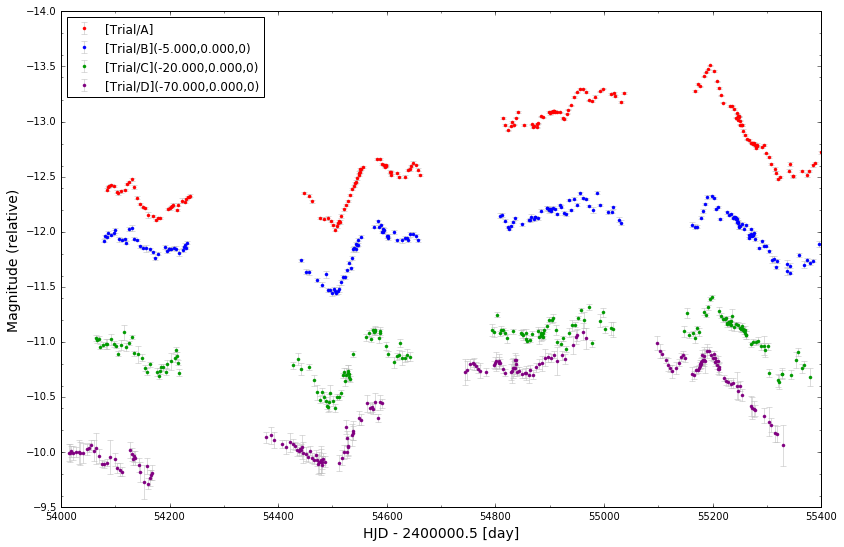

In [23]:
pycs.gen.lc.display(lcs)

The most *IMPORTANT* step in this process. Write this information to a pickle file using the code below.

In [24]:
pycs.gen.util.writepickle(lcs, "trialcurves.pkl")

Wrote trialcurves.pkl


In further scripts, you can now import the data by reading this file. 

In [25]:
lcs = pycs.gen.util.readpickle("trialcurves.pkl")

Read trialcurves.pkl


We will now undo these shifts, and from now on we will "forget" about the true delays. 

In [26]:
for l in lcs:
        l.resetshifts()

You can do a variety of things with this file to find out more information. For example, running the script below will provide you with the number of points, gap length, shifts, median, mean, maximum, minimum, and the colour it is plotted in.  

In [ ]:
for l in lcs: print(l.longinfo())

To save this figure to a file: 

In [33]:
pycs.gen.lc.display(lcs, filename="fig_trialcurves.pdf")

Plot written to fig_trialcurves.pdf


Another thing we can do is export the data into a text file called "out_trialcurves.txt". In this case, since we have not altered the original data, this file will contain the same information as trialcurves.txt.

In [ ]:
for l in lcs:
    l.resetshifts() 
    
pycs.gen.util.multilcsexport(lcs, "out_trialcurves.txt", separator="\t", verbose=True, properties=None)

## Factoring Microlensing into the Light Curves: Script 2

Explain what this did; fix the tabs; what is the spline objec tand what is the lcs object when spline is called; talk about the optimized spline; put the dispertion after script 6? 

In [27]:
# %load /Users/milanwilliams/PyCS/demo/demo1/myopt.py

# This file is somehow the configuration of PyCS for the particular lens to be analysed.
# All the fine-tuning of methods happens here.
# This is done by defining the curve shifting functions that will be used in your scripts.

# A simple attempt to get a multi-purpose free-knot spline method :
def spl(lcs):
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=50)
    for l in lcs:
        l.resetml()
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=30)
    spline = pycs.spl.topopt.opt_fine(lcs, nit=10, knotstep=20)
    return spline

# The dispersion method :
rawdispersionmethod = lambda lc1, lc2 : pycs.disp.disps.linintnp(lc1, lc2, interpdist = 30.0)
dispersionmethod = lambda lc1, lc2 : pycs.disp.disps.symmetrize(lc1, lc2, rawdispersionmethod)
def disp(lcs):
	return pycs.disp.topopt.opt_full(lcs, rawdispersionmethod, nit=5, verbose=True)

# The regression difference method : (needs pymc) : uncomment import on line 6 !
#def regdiff(lcs):
#	return pycs.regdiff.multiopt.opt_ts(lcs, pd=5, scale=200.0, verbose=True)


# The small scale extrinsic variability, used to generated the synthetic curves:
def Atweakml(lcs):
	return pycs.sim.twk.tweakml(lcs, beta=-1.5, sigma=0.25, fmin=1/500.0, fmax=None, psplot=False)

def Btweakml(lcs):
	return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=0.9, fmin=1/500.0, fmax=None, psplot=False)

def Ctweakml(lcs):
	return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=1.5, fmin=1/500.0, fmax=None, psplot=False)

def Dtweakml(lcs):
	return pycs.sim.twk.tweakml(lcs, beta=-0.0, sigma=4.5, fmin=1/500.0, fmax=None, psplot=False)


First, let's redefine our variables to read the pickle file we created from Script 1. 

In [28]:
lcs = pycs.gen.util.readpickle("trialcurves.pkl")

Read trialcurves.pkl


This line will print the estimated shifts from before, used to align the different light curves to make them easier to read in our plot. 

In [29]:
for l in lcs: print (l)

[Trial/A]
[Trial/B](-5.000,0.000,0)
[Trial/C](-20.000,0.000,0)
[Trial/D](-70.000,0.000,0)


Let's try  curve shifting without correcting for variability, just to see what it looks like. This will be done by using the free-knot spline technique. It won't look very good, as the curves do not overlap without a microlensing model. 

In [31]:
spline = spl(lcs)

Starting opt_rough on initial delays :
AB  +38.54 | AC  +36.74 | AD  -27.78 | BC   -1.79 | BD  -66.32 | CD  -64.52
Aiming at curves A, B, C, D.
Starting ML optimization ...
Done !
First spline and ML opt done.
AB  +37.54 | AC  +26.74 | AD   -7.78 | BC  -10.79 | BD  -45.32 | CD  -34.52    (Iteration  1, r2 =  67898.9)
AB  +35.54 | AC  +25.74 | AD   -0.78 | BC   -9.79 | BD  -36.32 | CD  -26.52    (Iteration  2, r2 =  67809.0)
AB  +34.54 | AC  +24.74 | AD   -0.78 | BC   -9.79 | BD  -35.32 | CD  -25.52    (Iteration  3, r2 =  67800.1)
AB  +34.54 | AC  +23.74 | AD   -1.78 | BC  -10.79 | BD  -36.32 | CD  -25.52    (Iteration  4, r2 =  67800.7)
AB  +34.54 | AC  +23.74 | AD   -1.78 | BC  -10.79 | BD  -36.32 | CD  -25.52    (Iteration  5, r2 =  67800.7)
Rough time shifts done :
AB  +34.54 | AC  +23.74 | AD   -1.78 | BC  -10.79 | BD  -36.32 | CD  -25.52
Starting opt_rough on initial delays :
AB  +34.54 | AC  +23.74 | AD   -1.78 | BC  -10.79 | BD  -36.32 | CD  -25.52
Aiming at curves A, B, C, D.


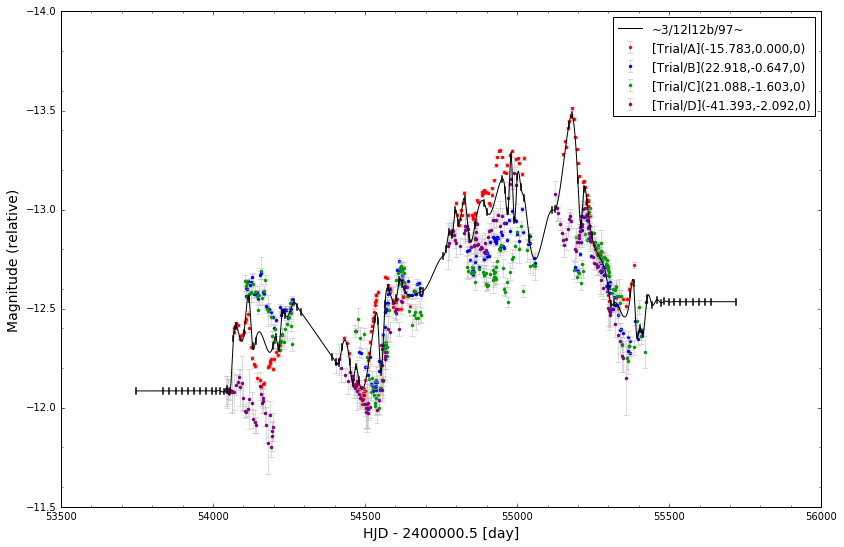

In [32]:
pycs.gen.lc.display(lcs, [spline])

Now let's print "Time Delays:" to make our work a bit easier to read. We will then compute the current time delays as from the current time shifts of each curve. 

In [35]:
print("Time Delays:")
print (pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True))

Time Delays:
AB  +38.70
AC  +36.87
AD  -25.61
BC   -1.83
BD  -64.31
CD  -62.48


To get even better results, let's factor in the microlensing models (e.g., polynomials) to our light curves. This choice is just an illustration. 

In [36]:
pycs.gen.polyml.addtolc(lcs[1], nparams=2, autoseasonsgap=60.0)
pycs.gen.polyml.addtolc(lcs[2], nparams=3, autoseasonsgap=600.0)
pycs.gen.polyml.addtolc(lcs[3], nparams=3, autoseasonsgap=600.0)

Now, let's try the free-knot spline optimization again. The result will be much better. 

Starting opt_rough on initial delays :
AB  +38.70 | AC  +36.87 | AD  -25.61 | BC   -1.83 | BD  -64.31 | CD  -62.48
Aiming at curves A.
Starting ML optimization ...
Working on the poly ML of [Trial/B](22.918,-0.647,0)|poly/2222|
Working on the poly ML of [Trial/C](21.088,-1.603,0)|poly/3|
Working on the poly ML of [Trial/D](-41.393,-2.092,0)|poly/3|
Done !
First spline and ML opt done.
AB  +34.70 | AC  +25.87 | AD  -40.61 | BC   -8.83 | BD  -75.31 | CD  -66.48    (Iteration  1, r2 =  24040.6)
AB  +28.70 | AC  +14.87 | AD  -50.61 | BC  -13.83 | BD  -79.31 | CD  -65.48    (Iteration  2, r2 =  22423.2)
AB  +20.70 | AC   +2.87 | AD  -58.61 | BC  -17.83 | BD  -79.31 | CD  -61.48    (Iteration  3, r2 =  19883.1)
AB  +11.70 | AC   -8.13 | AD  -62.61 | BC  -19.83 | BD  -74.31 | CD  -54.48    (Iteration  4, r2 =  16760.8)
AB   +3.70 | AC  -16.13 | AD  -65.61 | BC  -19.83 | BD  -69.31 | CD  -49.48    (Iteration  5, r2 =  14291.9)
Rough time shifts done :
AB   +3.70 | AC  -16.13 | AD  -65.61 | BC 

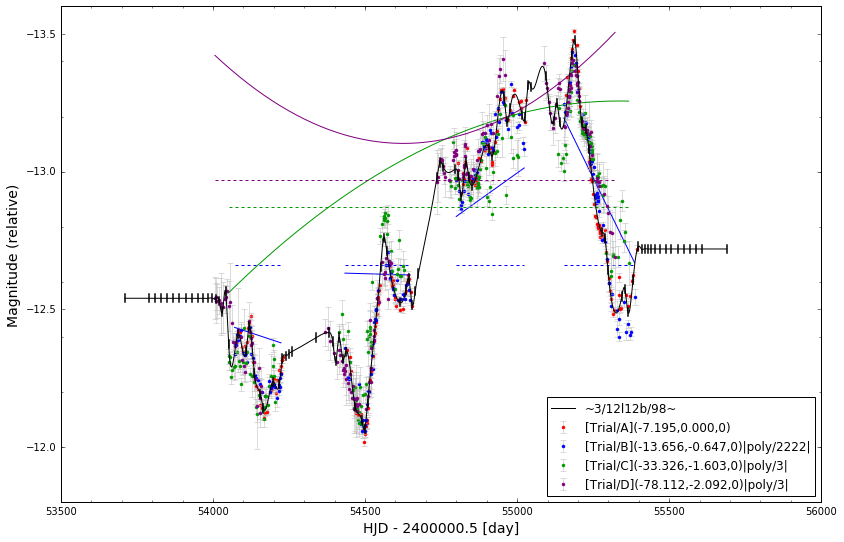

In [37]:
spline = spl(lcs) 
pycs.gen.lc.display(lcs, [spline])

Add the difference in time delays

In [38]:
print("Time Delays:")
print (pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True))

Time Delays:
AB   -6.46
AC  -26.13
AD  -70.92
BC  -19.67
BD  -64.46
CD  -44.79


## Creating the Free-Knot Spline Fit to Draw Synthetic Curves: Script 3

Making sure that our variables are properly defined...; check to see if this is used before

In [ ]:
lcs = pycs.gen.util.readpickle("trialcurves.pkl")

This script factors in the microlensing.

In [ ]:
pycs.gen.splml.addtolc(lcs[0], knotstep=150)
pycs.gen.splml.addtolc(lcs[1], knotstep=150)
pycs.gen.splml.addtolc(lcs[2], knotstep=150)
pycs.gen.splml.addtolc(lcs[3], knotstep=150)

This script redefines `spline`. 

In [ ]:
spline = myopt.spl(lcs)

This script displays our work in a PDF file for consistent readability, adding specifications to the plot to make it easy to understand. 

In [39]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500),filename="fig_modelfit.pdf")

Plot written to fig_modelfit.pdf


All of this work will now be written to a pickle file which will be used later. This file includes the lcs and their optimized microlensing splines. 

In [ ]:
pycs.gen.util.writepickle((lcs, spline), "optspline.pkl")

## Creating Copies of the Data to find the Time Delays: Script 4a

Defining our variables...

In [ ]:
lcs = pycs.gen.util.readpickle("trialcurves.pkl")

This script makes 200 copies of the data. These will be used to evaluate the instrinic variance of the optimizer and compute the best point estimates for the delays. 

In [ ]:
pycs.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=20, simset="copies")

This makes 1000 synthetic light curves with known true time delays, starting from the generative model. For this step we don't need the "raw" data. Instead, we wil use the the "optimized" light curves, with their shifts and microlensing models from prior steps, and the spline representing the intrinsic QSO variability. 

In [ ]:
(modellcs, modelspline)  = pycs.gen.util.readpickle("optspline.pkl")

At this place, *only* if you know what you are doing, you can manually adjust the microlensing or the delays. If not, run this script. This will run 20 simulations for each element in the pickle file. 

In [ ]:
pycs.sim.draw.saveresiduals(modellcs, modelspline)
pycs.sim.draw.multidraw(modellcs, modelspline, n=20, npkl=50, simset="1Kset1",
        truetsr=8.0, tweakml=[myopt.Atweakml, myopt.Btweakml, myopt.Ctweakml, myopt.Dtweakml])

Note
********************************************************
Variable Explanations:
"1Kset1" is a name that you can freely choose for your specific set of simulations. 
"truetsr=8.0" means that the synthetic curves will get random true time shifts in a range of about 8.0 days around the time shifts of the model lcs. 

In [4]:
! echo $PYTHONPATH

:/Users/milanwilliams/PyCS/


In [5]:
import myopt

ImportError: No module named myopt

In [10]:
import myopt

ImportError: No module named myopt